In [34]:
# Based on Amar's matlab code
import numpy as np
from shapely.geometry import LineString, Point

import time

parameters = {}

parameters['time'] = time.strftime('%d%b%H%M', time.localtime())
parameters['doi_size'] = 1.5
parameters['alpha'] = 1e2
parameters['num_iter'] = 1,
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 1000  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz 2.4e9
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 40,  # dB
parameters['grid_resolution'] = 0.05
parameters['detection_size'] = 0.1

def calculate_distance(point1, point2):
    return np.sqrt((point1[0]-point2[0])**2+(point1[1]-point2[1])**2)



def get_device_coordinates(parameters):
    doi_size = parameters['doi_size']
    num_deivces = len(parameters['device_indices'])

    line = LineString(((0.0, 0.0), (0.0, doi_size), (doi_size, doi_size), (doi_size, 0.0), (0.0, 0.0)))

    distances = np.linspace(0, line.length, num_deivces+1)

    points = [line.interpolate(distance) for distance in distances[:-1]]

    xx = [round(point.x, 3) for point in points]
    yy = [round(point.y, 3) for point in points]

    return xx, yy


def get_grid_coordinates(parameters):
    x = np.linspace(0.025, 1.475, int(parameters['doi_size']/parameters['grid_resolution']))

    y = np.linspace(0.025, 1.475, int(parameters['doi_size']/parameters['grid_resolution']))

    xx, yy = np.meshgrid(x, y)

    return xx, yy


device_xx, device_yy = get_device_coordinates(parameters)


grid_xx, grid_yy = get_grid_coordinates(parameters)

dist_txrx = np.zeros((parameters['num_devices'], parameters['num_devices']))
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        dist_txrx[tx][rx] = calculate_distance((device_xx[tx], device_yy[tx]), (device_xx[rx], device_yy[rx]))

dist_grid2device = np.zeros((int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution']), parameters['num_devices']))
for y in range(int(parameters['doi_size']/parameters['grid_resolution'])):
    for x in range(int(parameters['doi_size']/parameters['grid_resolution'])):
        for device in range(parameters['num_devices']):
            dist_grid2device[x][y][device] = (calculate_distance((grid_xx[x][y], grid_yy[x][y]), (device_xx[device], device_yy[device])))


In [35]:
F_RTI = np.zeros(((parameters['num_devices'])*(parameters['num_devices']-1), int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution'])))

idx = 0
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        if tx != rx:
            Thresh = 2*np.sqrt(dist_txrx[tx][rx]**2/4+parameters['detection_size']**2)
            foc_sum = dist_grid2device[:, :, rx] + dist_grid2device[:, :, tx]
            foc_sum[foc_sum>Thresh]=0
            foc_sum[foc_sum!=0]=1
            F_RTI[idx] = foc_sum
            idx += 1

F_RTI = F_RTI.reshape((parameters['num_devices'])*(parameters['num_devices']-1), -1)

In [36]:
start = time.time()

In [37]:
from functions import *

Pinc = np.load('result/Pinc.npy')
Pinc = magnitude_to_db(abs(np.mean(np.squeeze(Pinc), axis=2)), parameters['receiver_gain'])
Pinc = Pinc[~np.eye(Pinc.shape[0],dtype=bool)].reshape(-1,1)

In [38]:
Ptot = np.load('result/Ptot.npy')
Ptot = magnitude_to_db(abs(np.mean(np.squeeze(Ptot), axis=2)), parameters['receiver_gain'])
Ptot = Ptot[~np.eye(Ptot.shape[0],dtype=bool)].reshape(-1,1)

In [39]:
Pryt = Pinc - Ptot

In [40]:
output = np.matmul(np.linalg.solve((np.matmul(F_RTI.T, F_RTI) + parameters['alpha'] * np.identity((int(parameters['doi_size']/parameters['grid_resolution'])**2))),  F_RTI.T), Pryt)

In [41]:
output = output / output.max()

In [42]:
output[output<0] = 0

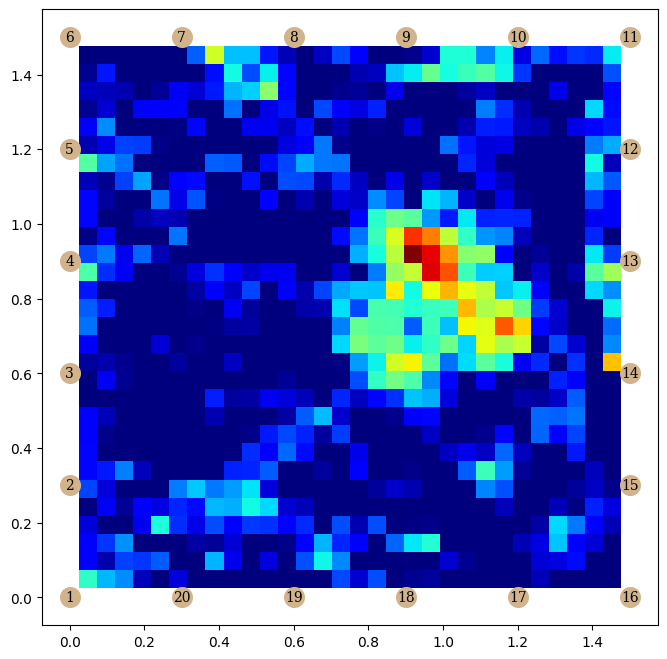

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

fontdict = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 10,
            }

plt.imshow(output.reshape((30,30)), extent=[0.025, 1.475, 0.025, 1.475], cmap='jet')

for i in range(parameters['num_devices']):
    plt.scatter(device_xx[i], device_yy[i], c='tan', s=200)
    plt.text(x=device_xx[i], y=device_yy[i]-0.01, s=i+1, fontdict=fontdict, ha='center')
plt.show()

In [44]:
import numpy as np
import time

parameters = {}

parameters['time'] = time.time()
parameters['num_devices'] = 20
parameters['device_indices'] = [x+1 for x in range(parameters['num_devices'])]

# device parameters
parameters['sample_rate'] = 1e6  # Hz
parameters['num_samples'] = 100  # number of samples per call to rx()
parameters['center_freq'] = 2.4e9  # Hz
parameters['bandwidth'] = 10  # Hz
parameters['transmitter_attenuation'] = 0  # dB
parameters['receiver_gain'] = 30  # dB
parameters['wavelength'] = 3e8/parameters['center_freq']

# imaging parameters
parameters['doi_size'] = 1.5
parameters['alpha'] = 0.05 #1e2
parameters['grid_resolution'] = 0.05
parameters['detection_size'] = 0.1
parameters['pixel_size'] = (int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution'])) 

parameters['eterm'] = 1
parameters['k0'] = 2*np.pi/parameters['wavelength']

    
Pinc = np.load('result/Pinc.npy')
Ptot = np.load('result/Ptot.npy')

Pinc = magnitude_to_db(abs(np.mean(np.squeeze(Pinc), axis=2)), parameters['receiver_gain'])
Pinc = Pinc[~np.eye(Pinc.shape[0],dtype=bool)].reshape(-1,1)


Ptot = magnitude_to_db(abs(np.mean(np.squeeze(Ptot), axis=2)), parameters['receiver_gain'])
Ptot = Ptot[~np.eye(Ptot.shape[0],dtype=bool)].reshape(-1,1)

In [45]:
Pryt=(Ptot-Pinc)/(20*np.log10(np.exp(1)))

In [46]:
cellrad = (np.sqrt(parameters['grid_resolution']**2/np.pi)*2)/2

In [47]:
from scipy.special import hankel1, jv

E_d = (1j/4)*hankel1(0, parameters['k0']*dist_txrx)
E_inc = (1j/4)*hankel1(0, parameters['k0']*dist_grid2device)

In [48]:
E_d.shape
dist_txrx.shape


(20, 20)

In [49]:
E_inc.shape

(30, 30, 20)

In [52]:
Zryt=((1j*np.pi*cellrad/(2*parameters['k0']))*jv(1,parameters['k0']*cellrad)*hankel1(0, parameters['k0']*dist_grid2device.T))

In [69]:
Fryt = np.zeros(((parameters['num_devices'])*(parameters['num_devices']-1), int(parameters['doi_size']/parameters['grid_resolution']), int(parameters['doi_size']/parameters['grid_resolution'])), dtype=complex)

idx = 0
for tx in range(parameters['num_devices']):
    for rx in range(parameters['num_devices']):
        if tx != rx:
            Fryt[idx] = ((parameters['k0']**2)*((Zryt[rx, :, :]*(E_inc[:, :, tx]).T)/(E_d[tx][rx])))
            
            idx += 1

In [73]:
Fryt = Fryt.reshape(380, -1)

In [54]:
FrytB = np.concatenate((Fryt.real, -Fryt.imag)).reshape(380, -1)

In [55]:
FrytB.T.shape

(1800, 380)

In [56]:
U_l = FrytB.shape[1]

In [57]:
lambda_max = np.linalg.norm(np.matmul(FrytB.T, Pryt), ord=2)

In [58]:
(np.matmul(FrytB.T, FrytB) + lambda_max * parameters['alpha'] * np.identity(U_l))

array([[ 1.71222902e+01,  1.52666966e+00,  1.30895286e+00, ...,
        -2.81316185e-01,  5.20879986e-01,  7.98405620e-01],
       [ 1.52666966e+00,  1.21934564e+01,  3.01126025e-01, ...,
         2.41441204e-01,  1.12621140e-02,  8.32749364e-01],
       [ 1.30895286e+00,  3.01126025e-01,  1.10208624e+01, ...,
         3.23465551e-01,  2.65614601e-01,  5.47359668e-01],
       ...,
       [-2.81316185e-01,  2.41441204e-01,  3.23465551e-01, ...,
         1.10208624e+01,  3.01126025e-01,  1.30895286e+00],
       [ 5.20879986e-01,  1.12621140e-02,  2.65614601e-01, ...,
         3.01126025e-01,  1.21934564e+01,  1.52666966e+00],
       [ 7.98405620e-01,  8.32749364e-01,  5.47359668e-01, ...,
         1.30895286e+00,  1.52666966e+00,  1.71222902e+01]])

In [59]:
# O = (FrytB.'*FrytB + lambda_max*alph*eye(U_l))\FrytB.'*Pryt

Oimag = np.matmul(np.linalg.solve((np.matmul(FrytB.T, FrytB) + lambda_max * parameters['alpha'] * np.identity(U_l)),  FrytB.T), Pryt)[parameters['pixel_size'][0]**2:]

In [60]:
epr = 4*np.pi*(Oimag*0.5)/parameters['wavelength']

epr[epr < 0] = 0

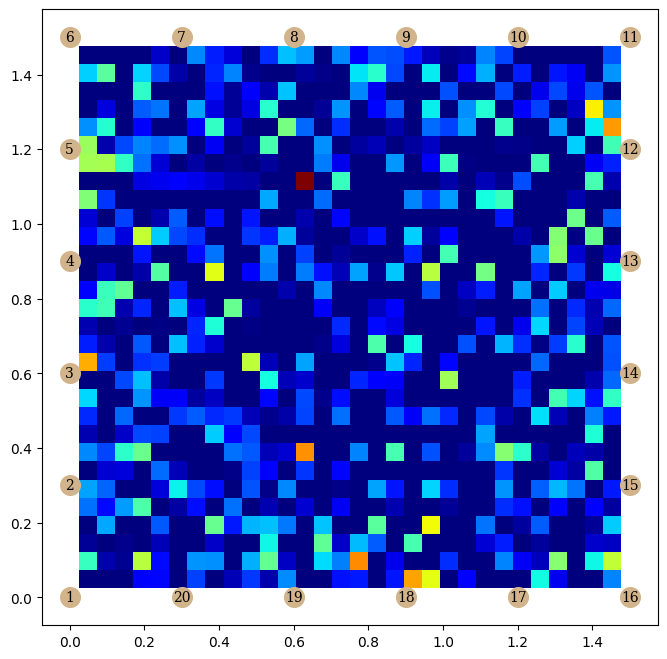

In [61]:

plt.figure(figsize=(8, 8))

fontdict = {'family': 'serif',
            'color':  'black',
            'weight': 'normal',
            'size': 10,
            }

plt.imshow(epr.reshape((30,30)), extent=[0.025, 1.475, 0.025, 1.475], cmap='jet')

for i in range(parameters['num_devices']):
    plt.scatter(device_xx[i], device_yy[i], c='tan', s=200)
    plt.text(x=device_xx[i], y=device_yy[i]-0.01, s=i+1, fontdict=fontdict, ha='center')
plt.show()

In [62]:
epr.max()

7.2215452072391875

In [63]:
import scipy.io


haha = scipy.io.loadmat("/home/lowong/Downloads/Forward_and_inverse_xPRA_RTI_codes - Anders/distanceED.mat")['distRxRn']

haha = np.array(haha)
haha.shape


(20, 900)

In [64]:
dist_grid2device.shape

(30, 30, 20)

In [65]:
dist_grid2device.reshape(900, -1).T - haha

array([[-1.43985651, -1.34616234, -1.24775177, ...,  0.53620735,
         0.57400888,  0.61075316],
       [-1.22428258, -1.16624867, -1.10015422, ...,  0.62702949,
         0.66956577,  0.71053629],
       [-1.0075708 , -0.95676526, -0.90195574, ...,  0.74591712,
         0.79399075,  0.83965022],
       ...,
       [ 0.29981385,  0.2997838 ,  0.29974568, ..., -0.11661155,
        -0.12439755, -0.13189327],
       [-0.29981385, -0.2997838 , -0.29974568, ...,  0.11661155,
         0.12439755,  0.13189327],
       [-0.8991319 , -0.89889312, -0.89851396, ...,  0.33982615,
         0.36299831,  0.38538561]])

In [67]:
Fryt.shape

(380, 30, 30)

In [68]:
E_ds1

NameError: name 'E_ds1' is not defined

In [76]:
Fryt = np.zeros(((parameters['num_devices'])*(parameters['num_devices']-1), int(parameters['doi_size']/parameters['grid_resolution'])**2), dtype=complex)

Fryt.shape

(380, 900)

In [79]:
Zryt=((1j*np.pi*cellrad/(2*parameters['k0']))*
      jv(1,parameters['k0']*cellrad)*
      hankel1(0, parameters['k0']*dist_grid2device.T))

In [78]:
jv(1,parameters['k0']*cellrad)

0.5451129257719947